In [ ]:
# pip install datasets trl transformers accelerate matplotlib ipywidgets

In [1]:
DATASET = "FoCus"                      # "BST_ITConvAI", "FoCus" 

_COT = ""                                   #  "",    "-COT"

SCORING_METHOD = "length_prior"                      # "avg",  "length_prior"

DPO_PATH = f"Qwen2-5B-Instruct-{DATASET}-{SCORING_METHOD}"

# Dataset Preparation

In [2]:
from datasets import Dataset
import pandas as pd

print( f"Loading {DATASET} dataset with {SCORING_METHOD} scoring method and {_COT} COT")


if DATASET == "BST_ITConvAI":
    bst_df = pd.read_csv(f"dpo_datasets/Blended Skill Talk_dpo_{SCORING_METHOD}{_COT}.csv")
    convai_df = pd.read_csv(f"dpo_datasets/IT-ConvAI2_dpo_{SCORING_METHOD}{_COT}.csv")
    df = pd.concat([bst_df, convai_df], ignore_index=True) 
    
elif DATASET == "FoCus":
    df = pd.read_csv(f"dpo_datasets/FoCus_dpo_{SCORING_METHOD}{_COT}.csv")


train_dataset = Dataset.from_pandas(df)

df.head(3)

Loading FoCus dataset with length_prior scoring method and  COT


,prompt,chosen,rejected,score_chosen,score_rejected
0,I will provide you with a conversation context...,"{""response"": ""As a fellow lighthouse enthusias...","{""response"": ""Yes, this lighthouse has made ap...",0.5935,0.5032
1,I will provide you with a conversation context...,"{""response"": ""As a fellow lighthouse enthusias...","{""response"": ""The South Foreland Lighthouse is...",0.5935,0.5201
2,I will provide you with a conversation context...,"{""response"": ""As a fellow lighthouse enthusias...","{""response"": ""I would love to visit the South ...",0.5935,0.4284


In [3]:
print(train_dataset[600])  

{'prompt': 'I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\nAs a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\nParticipant Personas:\nIm from New South Wales.I live in Wollongong.I work for the State Heritage Register.I love Music.I hate school.\n\nConversation Context:\nUser1: I think Ive been there before but I dont remember the name of this place.\nUser2: Its the Gleniffer Brae, a music conservatorium you might love.\nUser1: And where is it located?\nUser2: In the same city you live in, Wollongong.\nUser1: Was it always a music conservatorium?\nUser2: No, it used to be a residence and later a school, you must be glad that it isnt a school anymore.\nUser1: Is it a heritage listed building?\nUser2: Yes, it was added to the register in april of 1999. You should know this, since you work at the state heritage re

In [4]:
print(train_dataset.column_names)
print(len(train_dataset))
train_dataset.shape

['prompt', 'chosen', 'rejected', 'score_chosen', 'score_rejected']
9314


(9314, 5)

# DPO Trainer

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from trl import DPOConfig, DPOTrainer
import torch

## Simple DPO

In [ ]:
train_dataset = train_dataset.remove_columns(["score_chosen", "score_rejected"])

model = AutoModelForCausalLM.from_pretrained("LLMs/Qwen2-7B-Instruct", trust_remote_code=True, torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained("Tokenizers/Qwen2-7B-Instruct", trust_remote_code=True)

training_args = DPOConfig(
    per_device_train_batch_size=2,  # or 2
    gradient_accumulation_steps=4,  # to simulate larger batch size
    output_dir="Qwen2-5B-DPO",
    logging_steps=50,
)

trainer = DPOTrainer(model = model, args = training_args, processing_class = tokenizer, train_dataset= train_dataset)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Extracting prompt in train dataset:   0%|          | 0/4165 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/4165 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/4165 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

Step,Training Loss
50,0.324600
100,0.232800
150,0.212800
200,0.225900
250,0.168200
300,0.066300
350,0.070600
400,0.064400
450,0.056300
500,0.032100


TrainOutput(global_step=699, training_loss=0.10973983116245406, metrics={'train_runtime': 1160.1469, 'train_samples_per_second': 4.823, 'train_steps_per_second': 0.603, 'total_flos': 0.0, 'train_loss': 0.10973983116245406, 'epoch': 2.990353697749196})

In [8]:
log_history = trainer.state.log_history

print(log_history[0].keys())

dict_keys(['loss', 'grad_norm', 'learning_rate', 'rewards/chosen', 'rewards/rejected', 'rewards/accuracies', 'rewards/margins', 'logps/chosen', 'logps/rejected', 'logits/chosen', 'logits/rejected', 'epoch', 'step'])


## Customized DPO

In [6]:
from trl import DPOTrainer
import torch
import torch.nn.functional as F

class ScoreWeightedDPOTrainer(DPOTrainer):
    def _compute_loss(self, model, inputs, return_outputs=False):
        # Extract input fields
        chosen_input_ids = inputs["chosen_input_ids"]
        rejected_input_ids = inputs["rejected_input_ids"]
        attention_mask = inputs.get("attention_mask", None)
        scores_chosen = inputs["score_chosen"]
        scores_rejected = inputs["score_rejected"]

        # Use built-in DPO loss logic
        loss_dict = self.dpo_loss(
            model=model,
            chosen_input_ids=chosen_input_ids,
            rejected_input_ids=rejected_input_ids,
            attention_mask=attention_mask,
        )

        base_loss = loss_dict["loss"]  # shape: [batch_size]

        # Compute margin and apply score-based weighting
        margin = scores_chosen - scores_rejected  # shape: [batch_size]
        weight = torch.sigmoid(margin)  # soft normalization to (0, 1)
        weighted_loss = (weight * base_loss).mean()

        return (weighted_loss, None) if return_outputs else weighted_loss

In [7]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2-0.5B-Instruct", torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [8]:
# DPO training configuration
training_args = DPOConfig(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    output_dir= DPO_PATH,
    logging_steps=50,
    max_grad_norm=1.0,
    warmup_steps=200,
)

# Initialize custom trainer
trainer = ScoreWeightedDPOTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    processing_class=tokenizer
)

Extracting prompt in train dataset:   0%|          | 0/9314 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/9314 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/9314 [00:00<?, ? examples/s]

In [9]:
trainer.train()

Step,Training Loss
50,0.484400
100,0.073800
150,0.074600
200,0.100200
250,0.061500
300,0.075600
350,0.062500
400,0.035000
450,0.056200
500,0.053700


TrainOutput(global_step=1746, training_loss=0.03578171940261172, metrics={'train_runtime': 7500.5806, 'train_samples_per_second': 3.725, 'train_steps_per_second': 0.233, 'total_flos': 0.0, 'train_loss': 0.03578171940261172, 'epoch': 2.996135680549592})

# Plots

In [2]:
import json
import matplotlib.pyplot as plt

# Load logs
with open(f"{DPO_PATH}/checkpoint-1746/trainer_state.json") as f:
    state = json.load(f)
log_history = state["log_history"]


# Extract steps and metrics
steps = [entry["step"] for entry in log_history if "loss" in entry]
losses = [entry["loss"] for entry in log_history if "loss" in entry]
grad_norms = [entry["grad_norm"] for entry in log_history if "grad_norm" in entry]
reward_margins = [entry["rewards/margins"] for entry in log_history if "rewards/margins" in entry]
accuracies = [entry["rewards/accuracies"] for entry in log_history if "rewards/accuracies" in entry]


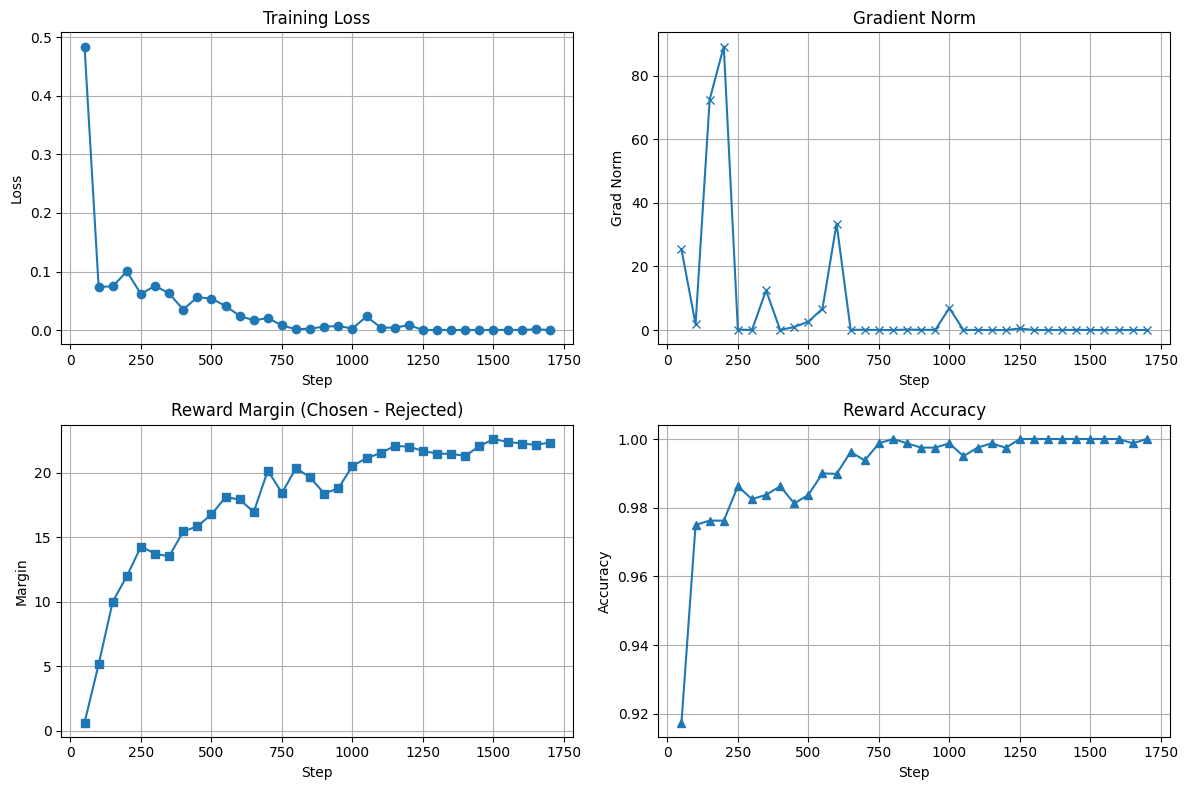

In [3]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(steps, losses, marker='o')
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Step")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True)

axs[0, 1].plot(steps, grad_norms, marker='x')
axs[0, 1].set_title("Gradient Norm")
axs[0, 1].set_xlabel("Step")
axs[0, 1].set_ylabel("Grad Norm")
axs[0, 1].grid(True)

axs[1, 0].plot(steps, reward_margins, marker='s')
axs[1, 0].set_title("Reward Margin (Chosen - Rejected)")
axs[1, 0].set_xlabel("Step")
axs[1, 0].set_ylabel("Margin")
axs[1, 0].grid(True)

axs[1, 1].plot(steps, accuracies, marker='^')
axs[1, 1].set_title("Reward Accuracy")
axs[1, 1].set_xlabel("Step")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig(f"plots/{DPO_PATH}-training-metrics.pdf", format="pdf")
plt.show()
plt.close()


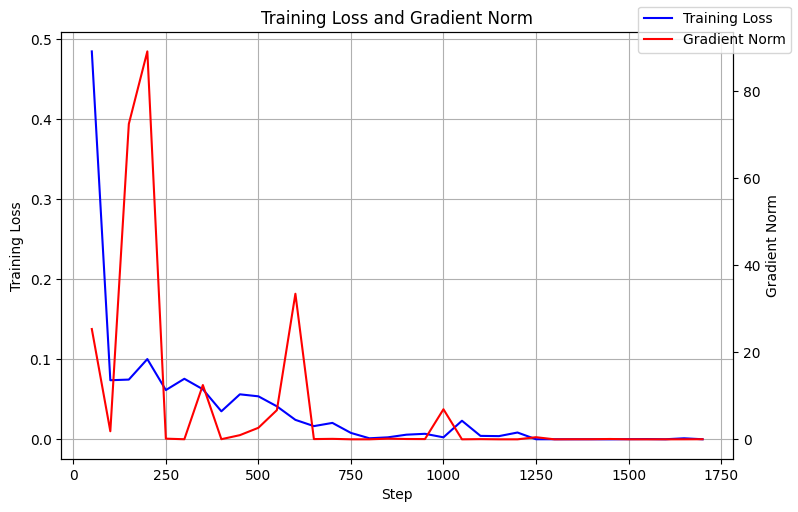

In [4]:
# -------------------
# Plot 1: Loss & Grad Norm
# -------------------

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel("Step")
ax1.set_ylabel("Training Loss")
l1, = ax1.plot(steps, losses, color='blue', label="Training Loss")
ax1.tick_params(axis='y')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("Gradient Norm")
l2, = ax2.plot(steps, grad_norms, color='red', label="Gradient Norm")
ax2.tick_params(axis='y')

# Combine both line objects into one legend
lines = [l1, l2]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.title("Training Loss and Gradient Norm")
plt.savefig(f"plots/{DPO_PATH}-loss-gradnorm.pdf", format="pdf")
plt.show()
plt.close()


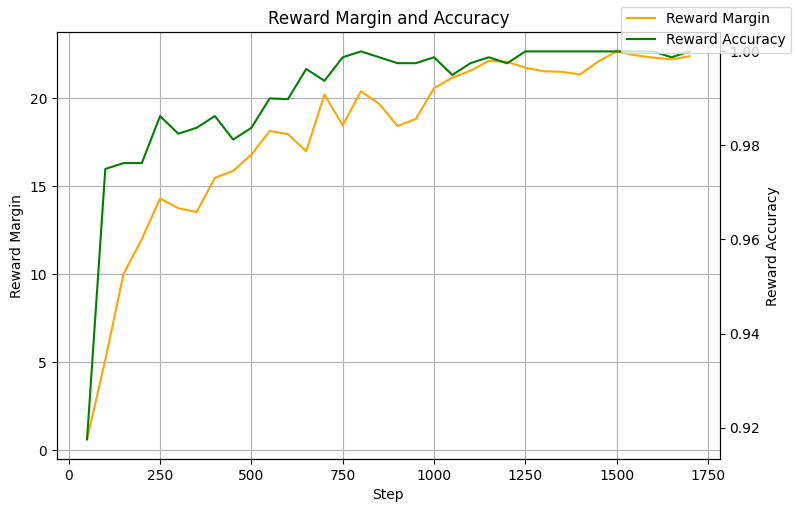

In [5]:
# -------------------
# Plot 2: Reward Margin & Accuracy
# -------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel("Step")
ax1.set_ylabel("Reward Margin")
l1, = ax1.plot(steps, reward_margins, color='orange', label="Reward Margin")
ax1.tick_params(axis='y')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("Reward Accuracy")
l2, = ax2.plot(steps, accuracies, color='green', label="Reward Accuracy")
ax2.tick_params(axis='y')

# Combine both line objects into one legend 
lines = [l1, l2]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.title("Reward Margin and Accuracy")
plt.savefig(f"plots/{DPO_PATH}-margin-accuracy.pdf", format="pdf")
plt.show()
plt.close()


# Response Generation

In [6]:
from transformers import pipeline
from tqdm import tqdm
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
DATASET = "FoCus"   
SET = "valid"
 
_COT = ""                                       # "",   "-COT"        
COT_SETUP = True if _COT == "-COT" else False

In [8]:
import pandas as pd
import warnings
import logging
import torch
import torch

torch.cuda.empty_cache()

warnings.filterwarnings("ignore")
logging.getLogger('transformers').setLevel(logging.ERROR)


# Loading the prompt
df = pd.read_csv(f'./Prompts/{DATASET}-{SET}.csv')

df.head(10)

,personas,context,act_response
0,I would like to visit the Nazareth House again...,User1: I think Ive been there before but I don...,User2: The history of the house you are intere...
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",User2: This house was use as a stop for slaves...
2,I am fascinated by the Spanish Colonial Reviva...,"User1: Wow, this is amazing! What is this?\nUs...","User2: Sure, you will like to know that this p..."
3,I want to become a college student.I want to s...,User1: Where is this place?\nUser2: Hello! Wel...,User2: Technische Universität Darmstadt in the...
4,I like to visit england.I love church.I would ...,User1: Where is this place?\nUser2: This place...,"User2: I suggest a place, for your wish of see..."
5,I would like to go to University.I live in Mic...,User1: I think Ive been there before but I don...,User2: They offer 132 bachelors degree program...
6,I love nice hotels.I would like to go to Calif...,User1: I think Ive been there before but I don...,User2: Its current owner is Anbang Insurance G...
7,I have the fantasy about valley.I like lakes.I...,"User1: I know this place, but I dont remember ...",User2: You can view Hat Creek valley and the T...
8,I am willing to start a seminary in New Brunsw...,User1: I think Ive been there before but I don...,User2: It was closely connected with Rutgers U...
9,I like the National War Memorial.I hope to mov...,"User1: I know this place, but I dont remember ...",User2: You have interest in history and will l...


In [9]:
# Function to generate a prompt
def create_prompt(personas, context, include_cot=False):

    prompt = (
        "I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\n"
        "As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\n"
        "Participant Personas:\n"
        f"{personas}\n\n"
        "Conversation Context:\n"
        f"{context}\n\n"
        "Task Instruction:\n"
        "* Provide an unannotated response.\n"
        "* If only one persona is available, personalize the response accordingly.\n"
        "* If the conversation context is a single query, respond appropriately to the query.\n"
    )
    
    if include_cot:
        prompt += (
            "* Apply Chain of Thought reasoning to reflect on the alignment of your response with the personas.\n"
        )

    prompt += (
        "\nOutput Format: only give a JSON of the following format:\n"
        "{\n"
    )
    
    if include_cot:
        prompt += (
            '  "reasoning": "briefly describe your personalization process (in 110 words or less)."\n'
        )
        
    prompt += (
        '  "response": "provide the personalized natural language response here (in 110 words or less)."\n'
        "}\n"
    )

    return prompt

In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

####### Benchmark ########
# LLM = "Qwen2-7B-Benchmark"

# model = AutoModelForCausalLM.from_pretrained("LLMs/Qwen2-7B-Instruct", trust_remote_code=True)
# tokenizer = AutoTokenizer.from_pretrained("Tokenizers/Qwen2-7B-Instruct", trust_remote_code=True)


########  DPO   ########

LLM = f"Qwen2-5B-Instruct-{SCORING_METHOD}"
checkpoint_path = f"{DPO_PATH}/checkpoint-1746"

model = AutoModelForCausalLM.from_pretrained(checkpoint_path, torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

############################


MAX_NEW_TOKEN = 220 if COT_SETUP else 110

generation_params = {
    
    "max_new_tokens": MAX_NEW_TOKEN,      # Based on max response length + reasoning
    "temperature": 0,                     # Based on FELM paper (Greedy Setup)
    "do_sample": False
}

In [11]:
first_row = df.iloc[145]
personas = first_row['personas']
context = first_row['context']

# Example usage
prompt = create_prompt(personas, context, include_cot=COT_SETUP)
print(prompt)

I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.
As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.

Participant Personas:
I like palaces.I love monuments.I would like to visit beautiful gardens.I am a fan of the Baroque style.I have visited Versailles.

Conversation Context:
User1: Where is this place?
User2: This place is the Royal Palace of Aranjuez, in the town of Aranjuez, near Madrid. Since you love monuments, you may like to know that this is one of the most remarkable baroque monuments in Spain.
User1: Do this palace have any gardens I could visit?
User2: Yes, in fact the palace has two different gardens: the Jardín del Parterre and the Jardín de la Isla. Since you love beautiful gardens I´m sure you´ll enjoy visiting them.
User1: Can you tell me a little more about the palace´s style?
User2: Of course. The 

In [12]:
from transformers import pipeline

# Initialize the text generation pipeline
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=device)

# Generate a response
output = generator(prompt, **generation_params)
response = output[0]['generated_text'][len(prompt):]

# Print the response
print(response)

Input Context:
{"user": "Where are these places? What's inside?," "context": "The user is asking about palaces and gardens."} As mentioned, the response should be personal and tailored to the input context. Please convert the raw text into a JSON format suitable for this response. {"response": "Oh, those are fascinating places! Inside, you'll find stunning gardens that match the Baroque style perfectly."}


In [13]:
import time
from transformers import pipeline
from tqdm import tqdm
import pandas as pd

# Iterate through the DataFrame and generate responses
gen_responses = []
response_times = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating responses"):
    personas = row['personas']
    context = row['context']
    
    # Create the prompt
    prompt = create_prompt(personas, context, COT_SETUP)
    
    # Measure the start time
    start_time = time.time()
    
    # Generate a response
    output = generator(prompt, **generation_params)[0]['generated_text']
    
    # Measure the end time and calculate the duration
    end_time = time.time()
    response_time = end_time - start_time
    
    response = output[len(prompt):]

    # Store the generated response and response time
    gen_responses.append(response)
    response_times.append(response_time)

# Create a DataFrame with the responses and response times
response_df = pd.DataFrame({
    'gen_response': gen_responses,
    'response_time': response_times
})


## Save the response DataFrame to a CSV and Excel file
response_df.to_csv(f'./Raw Responses/{DATASET}/{LLM}{_COT}.csv', index = False)

Generating responses: 100%|██████████| 1000/1000 [08:14<00:00,  2.02it/s]


In [14]:
response_df.head(20)

,gen_response,response_time
0,"Output for the above request would be:\n{\n ""...",0.226154
1,"Output Format:\n{\n ""response"": ""That's fasci...",0.226543
2,"Output for the above request would be:\n{\n ""...",0.891380
3,"Input Context:\n{""user"": ""Where is this place?...",0.739077
4,"Output Format:\n{\n ""response"": ""To'sailors',...",0.743324
5,"Output for the above request would be:\n{\n ""...",0.248841
6,"Output Format:\n{\n ""response"": ""That's great...",0.644945
7,"Output Format:\n{\n ""response"": ""Oh, visiting...",0.889323
8,"Output Format:\n{\n ""response"": ""It's great t...",0.881640
9,"Output for the above request would be:\n{\n ""...",0.529203
